In [211]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
%config Completer.use_jedi = False
from datetime import datetime


In [2]:
df=pd.read_csv('/project/biocomplexity/COVID-19_commons/data/VDH_wastewater/processed_data/state_aggregation_CLI_case_hosp_wastewater_2023-04-23.csv',index_col=['time_value'])
df.index=pd.to_datetime(df.index)

In [3]:
temp=(df['BOW_cases'].ffill()).dropna()#shift().fillna()

In [4]:
df=df.ffill()

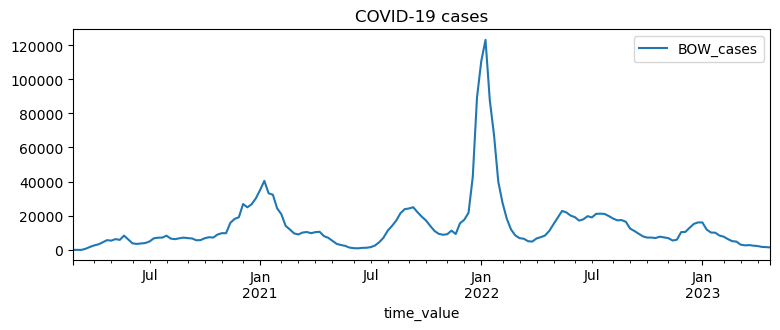

In [201]:
ax=df[['BOW_cases']].fillna(0).plot(figsize=(9, 3),title='COVID-19 cases')
# ax2=ax.twinx()
# df[['hosps_BOW_7d_avg']].fillna(0).plot(ax=ax2,color='#05A12F')


In [65]:
mod=sm.tsa.MarkovAutoregression(np.log(df[dep].dropna()),k_regimes=2,order=3,trend='c',switching_variance=True)

/home/aa5dw/miniconda3/envs/stats/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


In [66]:
res=mod.fit()

/home/aa5dw/miniconda3/envs/stats/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


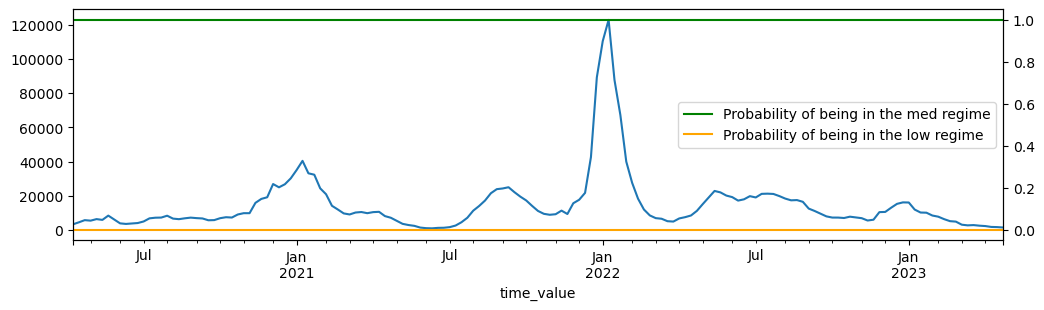

In [68]:
ax=df[dep].fillna(0).plot(figsize=(12, 3))
ax2=ax.twinx()
# res.smoothed_marginal_probabilities[2].plot(ax=ax2,label="Probability of being in the high regime", figsize=(12, 3), color='red')
res.smoothed_marginal_probabilities[1].plot(ax=ax2,label="Probability of being in the med regime", figsize=(12, 3), color='green')
res.smoothed_marginal_probabilities[0].plot(ax=ax2,label="Probability of being in the low regime", figsize=(12, 3), color='orange')
ax2.legend()
# ax2.axhline(y=0.5)

In [231]:
df

,Unnamed: 0,geo_value,geo_res,BOW_cases,count_of_cli_visits,coverage_adj_vl,hosps_BOW_7d_avg
time_value,,,,,,,
2020-03-01,0,VA,state,NaN,5758.0,NaN,NaN
2020-03-08,1,VA,state,NaN,7063.0,NaN,NaN
2020-03-15,2,VA,state,NaN,7675.0,NaN,NaN
2020-03-22,3,VA,state,671.0,5769.0,NaN,NaN
2020-03-29,4,VA,state,1747.0,4578.0,NaN,NaN
...,...,...,...,...,...,...,...
2023-03-26,160,VA,state,2465.0,10305.0,1.567777e+12,34.815000
2023-04-02,161,VA,state,2238.0,9277.0,8.978932e+11,30.968143
2023-04-09,162,VA,state,1734.0,8967.0,8.978932e+11,28.456714


In [114]:
# exog['coverage_adj_vl']=(exog['coverage_adj_vl']-exog['coverage_adj_vl'].mean())/exog['coverage_adj_vl'].std()

/home/aa5dw/miniconda3/envs/stats/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


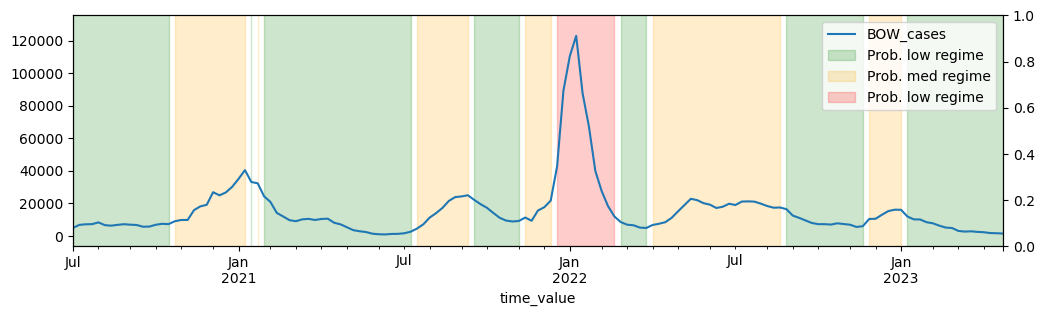

In [302]:
dep='BOW_cases'
exog=df[dep].shift().rename(dep+'_shift')#pd.concat((df[dep].shift(),df['coverage_adj_vl'],df['coverage_adj_vl'].shift().rename('coverage_adj_vl_shift')),axis=1).rename(columns={dep:dep+'_shift'})
data_wexog=pd.concat((df[dep],exog),axis=1,join='inner')
data_wexog=data_wexog.dropna()
data_wexog=data_wexog/np.max(data_wexog)


dt='2020-07-01'
for edt in [data_wexog.index.max()]:#['2021-04-01','2021-12-01','2022-06-01',data_wexog.index.max()]:#,]
    try:
        _,ax=plt.subplots(figsize=(12, 3))
        mod3 = sm.tsa.MarkovRegression(data_wexog.loc[dt:edt,dep], k_regimes=3, trend='c',switching_variance=True,exog=data_wexog.loc[dt:edt,[dep+'_shift']])#dep+'_shift',data_wexog.loc[dt:,[dep+'_shift','coverage_adj_vl']]np.log(data_wexog.loc[dt:,['coverage_adj_vl']].fillna(0))

        res3 = mod3.fit()

        probdf=res3.smoothed_marginal_probabilities
        probdf.loc[:,'Regime']=probdf.idxmax(axis=1)

        df.loc[dt:,dep].plot(ax=ax)
        mx=ax.get_ylim()[1]
        ax2=ax.twinx()
        ax.fill_between(probdf.index,mx,0,where=(probdf.Regime==0),color='green',alpha=0.2,label="Prob. low regime",interpolate=True,transform=ax.get_xaxis_transform(),facecolor='green')
        ax.fill_between(probdf.index,mx,0,where=(probdf.Regime==1),color='orange',alpha=0.2,label="Prob. med regime",interpolate=True,transform=ax.get_xaxis_transform(),facecolor='orange')
        ax.fill_between(probdf.index,mx,0,where=(probdf.Regime==2),color='red',alpha=0.2,label="Prob. low regime",interpolate=True,transform=ax.get_xaxis_transform(),facecolor='red')
        ax.legend()
    except:
        print(edt)
        continue


array([12.53486257,  8.08527983,  9.1647845 ])

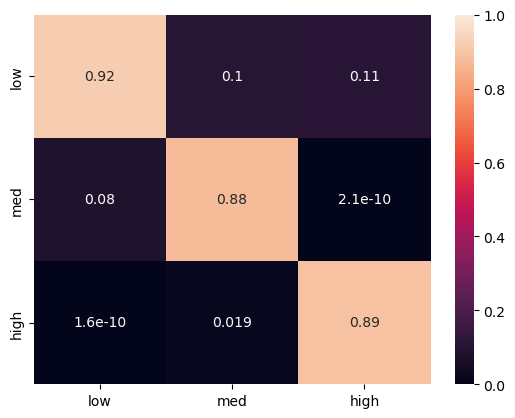

In [303]:
ax=sns.heatmap(res3.regime_transition.reshape(3,3),vmax=1,vmin=0,annot=True)
ax.set_xticklabels(['low','med','high'])
ax.set_yticklabels(['low','med','high'])

res3.expected_durations

/home/aa5dw/miniconda3/envs/stats/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


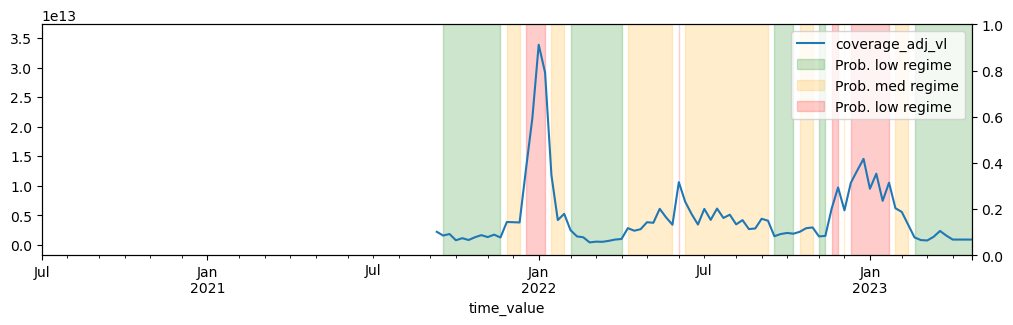

In [287]:
dt='2020-07-01'
for edt in [data_wexog.index.max()]:#['2021-04-01','2021-12-01','2022-06-01',data_wexog.index.max()]:#,]
    try:
        _,ax=plt.subplots(figsize=(12, 3))
        mod3 = sm.tsa.MarkovRegression(data_wexog.loc[dt:edt,dep], k_regimes=3, trend='c',switching_variance=True,exog=data_wexog.loc[dt:edt,[dep+'_shift']])#dep+'_shift',data_wexog.loc[dt:,[dep+'_shift','coverage_adj_vl']]np.log(data_wexog.loc[dt:,['coverage_adj_vl']].fillna(0))

        res3 = mod3.fit()

        probdf=res3.smoothed_marginal_probabilities
        probdf.loc[:,'Regime']=probdf.idxmax(axis=1)

        df.loc[dt:,dep].plot(ax=ax)
        mx=ax.get_ylim()[1]
        ax2=ax.twinx()
        ax.fill_between(probdf.index,mx,0,where=(probdf.Regime==0),color='green',alpha=0.2,label="Prob. low regime",interpolate=True,transform=ax.get_xaxis_transform(),facecolor='green')
        ax.fill_between(probdf.index,mx,0,where=(probdf.Regime==1),color='orange',alpha=0.2,label="Prob. med regime",interpolate=True,transform=ax.get_xaxis_transform(),facecolor='orange')
        ax.fill_between(probdf.index,mx,0,where=(probdf.Regime==2),color='red',alpha=0.2,label="Prob. low regime",interpolate=True,transform=ax.get_xaxis_transform(),facecolor='red')
        ax.legend()
    except:
        print(edt)
        continue


[Text(0, 0.5, 'low'), Text(0, 1.5, 'med'), Text(0, 2.5, 'high')]

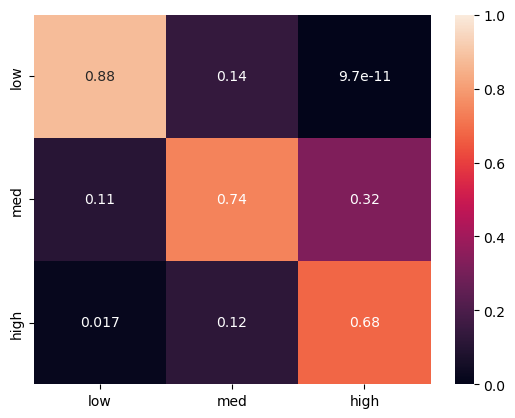

array([8.10227361, 3.8265782 , 3.09569374])

<Axes: xlabel='time_value'>

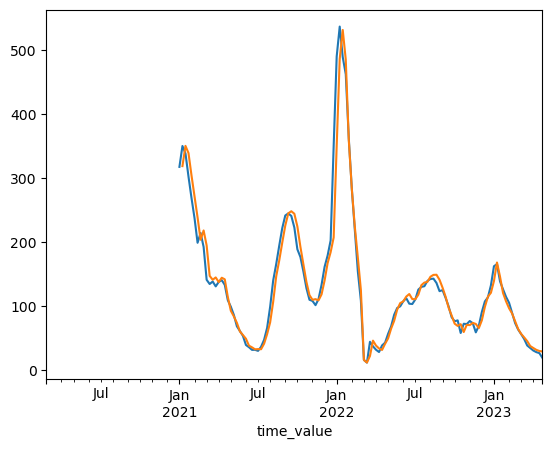

In [259]:
df[dep].plot()
(np.max(df[dep])*res3.predict()).plot()


<Axes: xlabel='time_value'>

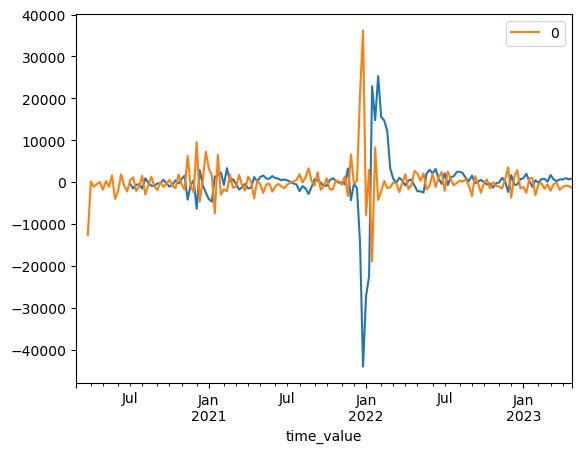

In [187]:
fig,ax=plt.subplots()
(np.max(df[dep])*res3.predict()-df[dep]).plot(ax=ax)
(np.max(df[dep])*temp).plot(ax=ax)

In [176]:
temp=pd.DataFrame(index=ind,data=(data-arima.predict_in_sample()))

In [196]:
(np.linalg.norm(np.max(df[dep])*temp)**2-np.linalg.norm(temp_ms)**2)/np.linalg.norm(np.max(df[dep])*temp)**2

-481341.3187497374

In [190]:
temp_ms=np.mean((np.max(df[dep])*res3.predict()-df[dep].dropna())**2)

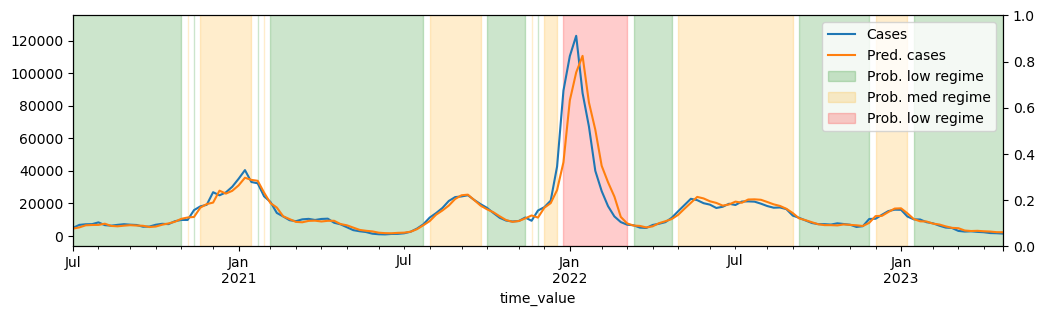

In [223]:
ax=df.loc[dt:edt,dep].dropna().plot(figsize=(12, 3),label='Cases')
(df[dep].max()*res3.predict()).plot(ax=ax,label='Pred. cases')
mx=ax.get_ylim()[1]
ax2=ax.twinx()
ax.fill_between(probdf.index,mx,0,where=(probdf.Regime==0),color='green',alpha=0.2,label="Prob. low regime",interpolate=True,transform=ax.get_xaxis_transform(),facecolor='green')
ax.fill_between(probdf.index,mx,0,where=(probdf.Regime==1),color='orange',alpha=0.2,label="Prob. med regime",interpolate=True,transform=ax.get_xaxis_transform(),facecolor='orange')
ax.fill_between(probdf.index,mx,0,where=(probdf.Regime==2),color='red',alpha=0.2,label="Prob. low regime",interpolate=True,transform=ax.get_xaxis_transform(),facecolor='red')
ax.legend()

In [163]:
data=data_wexog['BOW_cases'].values
ind=data_wexog.index
import pmdarima as pm
arima = pm.auto_arima(data, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=5,
                      seasonal=True, m=12)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-594.643, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-173.712, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-457.658, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-299.107, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-90.348, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=-597.612, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=-605.914, Time=0.04 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=-581.583, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=-599.606, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=-575.105, Time=0.03 sec
 ARIMA(3,0,2)(0,0,0)[12] intercept   : AIC=-605.109, Time=0.04 sec
 ARIMA(2,0,3)(0,0,0)[12] intercept   : AIC=-605.776, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-518.952, Time=0.02 sec
 ARIMA(1,0,3)(0,0,0)[12] intercept   : AIC=-602.265, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)

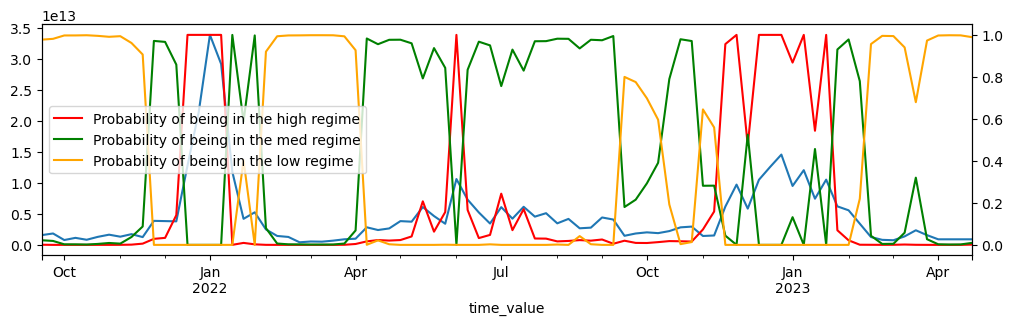

In [21]:
ax=df[dep].fillna(0).plot(figsize=(12, 3))
ax2=ax.twinx()
res3.smoothed_marginal_probabilities[2].plot(ax=ax2,label="Prob. high regime", figsize=(12, 3), color='red')
res3.smoothed_marginal_probabilities[1].plot(ax=ax2,label="Prob. med regime", figsize=(12, 3), color='green')
res3.smoothed_marginal_probabilities[0].plot(ax=ax2,label="Prob. low regime", figsize=(12, 3), color='orange')
ax2.legend()
# ax2.axhline(y=0.5)

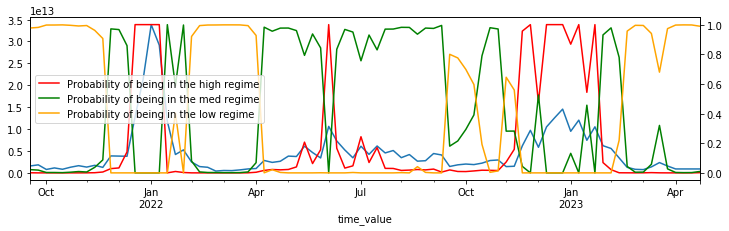

In [502]:
ax=df[dep].fillna(0).plot(figsize=(12, 3))
ax2=ax.twinx()
res3.smoothed_marginal_probabilities[2].plot(ax=ax2,label="Probability of being in the high regime", figsize=(12, 3), color='red')
res3.smoothed_marginal_probabilities[1].plot(ax=ax2,label="Probability of being in the med regime", figsize=(12, 3), color='green')
res3.smoothed_marginal_probabilities[0].plot(ax=ax2,label="Probability of being in the low regime", figsize=(12, 3), color='orange')
ax2.legend()
# ax2.axhline(y=0.5)

In [312]:
data_wexog['coverage_adj_vl']=np.log(data_wexog['coverage_adj_vl'])

In [501]:
res3.forecast(steps=1)

NotImplementedError: 

In [6]:
tpdf1=pd.read_csv('/project/biocomplexity/COVID-19_commons/data/VDH_wastewater/processed_data/district_aggregation_CLI_case_hosp_wastewater_2023-04-23.csv')

In [7]:
tpdf2=pd.read_csv('/project/biocomplexity/COVID-19_commons/data/VDH_wastewater/processed_data/district_aggregation_CLI_case_hosp_2023-04-30.csv')

In [10]:
tpdf1=tpdf1.set_index('time_value')

In [12]:
tpdf2=tpdf2.set_index('time_value')

In [508]:
data_wexog.shape

(84, 2)

In [510]:
res3.predict(start=80)

2023-04-02    0.037077
2023-04-09    0.031058
2023-04-16    0.031091
2023-04-23    0.031624
Freq: W-SUN, dtype: float64

In [19]:
tpdf=tpdf1[['geo_value','geo_res','count_of_cli_visits','coverage_adj_vl','hosps_BOW_7d_avg']].merge(tpdf2[['BOW_cases','geo_value','geo_res',]],left_index=True,right_index=True,on=['geo_value','geo_res'])

In [23]:
tpdf.to_csv('/project/biocomplexity/COVID-19_commons/data/VDH_wastewater/processed_data/district_aggregation_CLI_case_hosp_wastewater_2023-04-23.csv',index=None)

In [284]:
res3.params[8]*df[dep].max()

10545.039256981